In [23]:
import sys
sys.path.append('./src')
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from src.utils import *

In [15]:
transform = transforms.Compose([  
    transforms.ToTensor(), 
    ])

data_dir = "E:\\depth_None_True\\testset.pkl"
dataset = create_dataset_from_preprocessed(data_dir, transform=False)

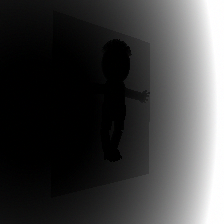

In [16]:
dataset[0][0]

In [13]:
result_path_list = get_subdirpath_list(directory_path='./results')
result_path_list

['results/bee05ba9a46ec18ba2a1f53691ac362a',
 'results/79202af7d55a988e8c4f0f68977116db',
 'results/ed9661104ef234e733b83e2bf1b013ff',
 'results/8f47eab51fde625cbe9e2e6b7fe92476',
 'results/adc3e41676c052b250af214dafdb6b82',
 'results/45a71c85c1d0ee1c110dd59829c7269c',
 'results/8c5acdb495021bdedb97867d8da1853e']

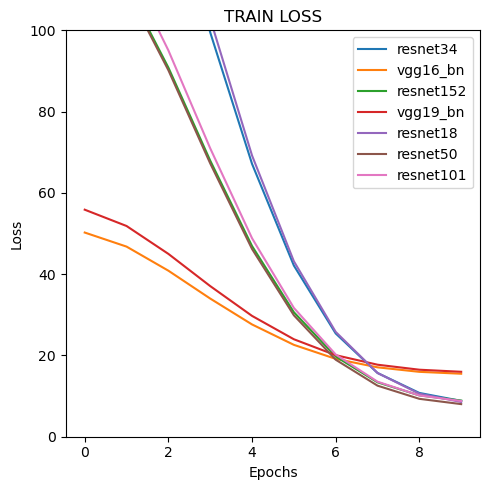

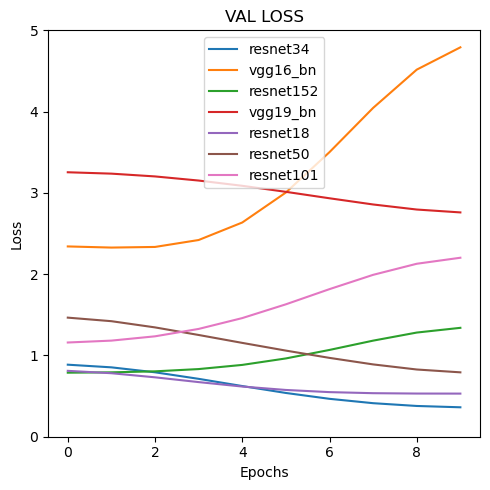

In [33]:
def log_vis(session_path_list, ylim=[0, 100], key='val', epochs=10, gaussian_smooth=True, sigma=3):
    plt.figure(figsize=(5,5))

    for path_ in session_path_list:
        cur_info_path = os.path.join(path_, 'info.json')
        cur_log_path = os.path.join(path_, 'train_log.json')

        log_curve = json2dict(cur_log_path)[f'{key}_loss'][0:epochs]
        log_label = json2dict(cur_info_path)['model_name']

        # Apply Gaussian smoothing
        if gaussian_smooth: 
            log_curve = gaussian_filter1d(log_curve, sigma=sigma)
        plt.plot(log_curve, label=log_label) 

    plt.title(f'{key.upper()} LOSS')
    plt.ylim(ylim)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.legend()

    # Save the plot
    # plt.savefig(os.path.join(save_dir, f'{key}_loss_plot.png'))

log_vis(result_path_list, key='train', ylim=[0,100])
log_vis(result_path_list, key='val', ylim=[0,5])

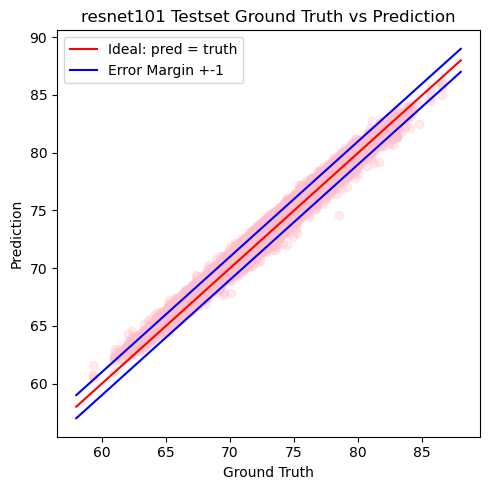

In [11]:
def pred_vis(session_path):
    pred_info_path = os.path.join(session_path, 'pred.json')
    model_info_path = os.path.join(session_path, 'info.json')

    pred_info = json2dict(pred_info_path)
    model_info = json2dict(model_info_path)
    model_name = model_info['model_name']

    gt = np.array(pred_info['true_labels']).reshape(1, -1)
    pred = np.array(pred_info['predictions']).reshape(1, -1)

    # Plot
    plt.figure(figsize=(5,5))
    plt.scatter(gt, pred, c='pink', alpha=0.3)
    plt.title(f'{model_name} Testset Ground Truth vs Prediction')

    # Create a line space for the ideal line where ground truth equals predictions
    line_space = np.linspace(58, 88, 30)
    plt.plot(line_space, line_space, 'r', alpha=1, label='Ideal: pred = truth')  # Red dashed line
    plt.plot(line_space, line_space + 1, 'b', alpha=1, label='Error Margin +-1')  # Blue dashed line for +1 error margin
    plt.plot(line_space, line_space - 1, 'b', alpha=1)  # Blue dashed line for -1 error margin

    plt.xlabel('Ground Truth')
    plt.ylabel('Prediction')
    plt.legend()
    plt.tight_layout()

    # Save the plot
    # plt.savefig(os.path.join(save_dir, f'{key}_loss_plot.png'))

pred_vis('results/8c5acdb495021bdedb97867d8da1853e')

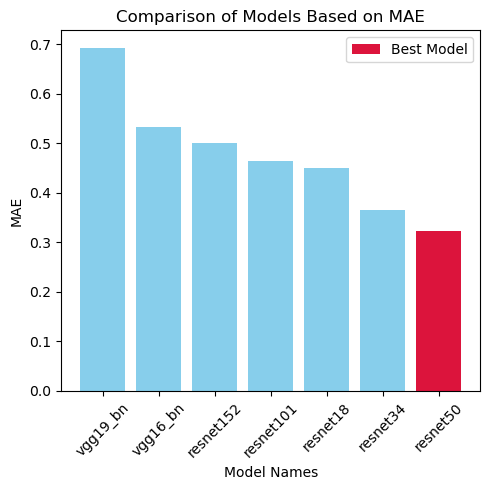

In [32]:
def metric_vis(session_path_list, metric, ylim=None):
    pred_info_path_list = []
    model_info_path_list = []
    for session_path in session_path_list:
        pred_info_path = os.path.join(session_path, 'pred.json')
        model_info_path = os.path.join(session_path, 'info.json')
        pred_info_path_list.append(pred_info_path)
        model_info_path_list.append(model_info_path)
    
    model_name_list = []
    metric_list = []
    for i in model_info_path_list:
        model_name_list.append(json2dict(i)['model_name'])
    for i in pred_info_path_list:
        pred_info = json2dict(i)
        gt = np.array(pred_info['true_labels']).reshape(1, -1)
        pred = np.array(pred_info['predictions']).reshape(1, -1)
        if metric == 'r2':
            r2 = r2_score(gt.reshape(-1, 1), pred.reshape(-1, 1))
            metric_list.append(r2)
        elif metric == 'acc':
            accuracy = np.mean(np.abs(gt - pred) <= 1)
            metric_list.append(accuracy)
        elif metric == 'mse':
            mse = mean_squared_error(gt, pred)
            metric_list.append(mse)
        elif metric == 'mae':
            mae = mean_absolute_error(gt, pred)
            metric_list.append(mae)
        else:
            print('Metric not yet supported.')
            return
    
    # Sort the metrics and model names based on the metric values
    sorted_indices = np.argsort(metric_list)[::-1]
    sorted_model_names = np.array(model_name_list)[sorted_indices]
    sorted_metrics = np.array(metric_list)[sorted_indices]
    
    # Color settings
    if metric == 'r2' or metric == 'acc':
        colors = ['crimson' if i == 0 else 'skyblue' for i in range(len(sorted_model_names))]
    elif metric == 'mse' or metric == 'mae':
        colors = ['crimson' if i == len(session_path_list)-1 else 'skyblue' for i in range(len(sorted_model_names))]
    
    # Create the bar plot
    plt.figure(figsize=(5, 5))
    bars = plt.bar(sorted_model_names, sorted_metrics, color=colors)
    
    # Highlight the best model
    if metric == 'r2' or metric == 'acc':
        bars[0].set_label('Best Model')
    elif metric == 'mse' or metric == 'mae':
        bars[len(session_path_list)-1].set_label('Best Model')
    plt.legend()
    
    plt.xlabel('Model Names')
    plt.ylabel(metric.upper())
    if ylim != None:
        plt.ylim(ylim)
    plt.title(f'Comparison of Models Based on {metric.upper()}')
    plt.xticks(rotation=45)
    plt.tight_layout()

metric_vis(result_path_list, 'mae')